Import the libraries necessary to analize data

In [618]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
import random
import seaborn as sns
import plotly.express as px

from collections import defaultdict
from scipy.stats import pearsonr

In [619]:
df = pd.read_csv('incidents_df_joined.csv', low_memory=False, sep=',', parse_dates=['date'])

Casting data types to match the content of each attribute (these instructions also set to NaN non-numerical values in numerical attributes)

In [620]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("Float64")
df["participant_gender1"] = df["participant_gender1"].astype("string")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Float64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Float64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Float64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Float64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Float64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Float64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Float64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df["party"] = df["party"].astype("string")
df["candidatevotes"] = df["candidatevotes"].astype("Int64")
df["totalvotes"] = df["totalvotes"].astype("Int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199379 entries, 0 to 199378
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       199378 non-null  datetime64[ns]
 1   state                      199378 non-null  string        
 2   city_or_county             199378 non-null  string        
 3   address                    185727 non-null  string        
 4   latitude                   199312 non-null  float64       
 5   longitude                  199312 non-null  float64       
 6   congressional_district     199378 non-null  Int64         
 7   state_house_district       178207 non-null  Int64         
 8   state_senate_district      184239 non-null  Int64         
 9   participant_age1           136186 non-null  Int64         
 10  participant_age_group1     161304 non-null  string        
 11  participant_gender1        166715 non-null  string  

Deleting the rows with all NaN values

In [621]:
print(f"df len before: {len(df)}")
df.dropna(how='all', inplace=True)
print(f"df len after: {len(df)}")

df len before: 199379
df len after: 199378


Removing duplicates

In [622]:
print("Before duplicate removal")
print(df.duplicated().value_counts())
df = df.drop_duplicates(keep='first')
print("\nAfter duplicate removal")
print(df.duplicated().value_counts())

Before duplicate removal
False    199125
True        253
Name: count, dtype: int64

After duplicate removal
False    199125
Name: count, dtype: int64


Setting negative values (less than 0) to NaN, for all numerical attributes related to the incident participants

In [623]:
columns_to_check = ['participant_age1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants']
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df.loc[df[i] < 0, i] = np.nan


## Age
('participant_age1', 'min_age_participants', 'avg_age_participants', 'max_age_participants')


As seen in D.U., given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN, considering that a person with more than 120 years has not ever lived, here the [source](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people).

In [624]:
df.loc[(df["avg_age_participants"] > 120), "avg_age_participants"] = np.nan
df.loc[(df['min_age_participants'] > 120), "min_age_participants"] = np.nan
df.loc[(df['max_age_participants'] > 120), "max_age_participants"] = np.nan
df.loc[(df["participant_age1"] > 120), "participant_age1"] = np.nan

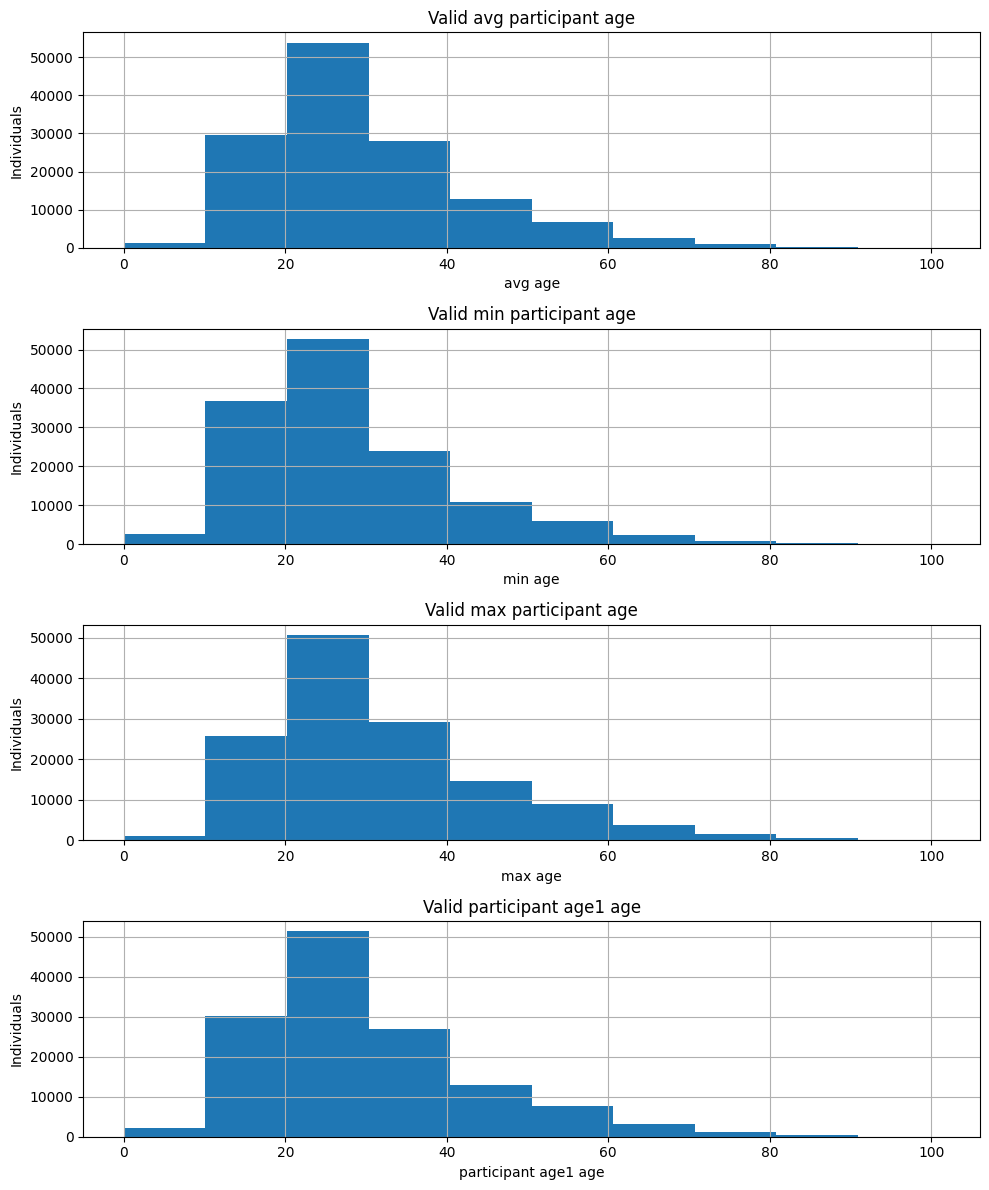

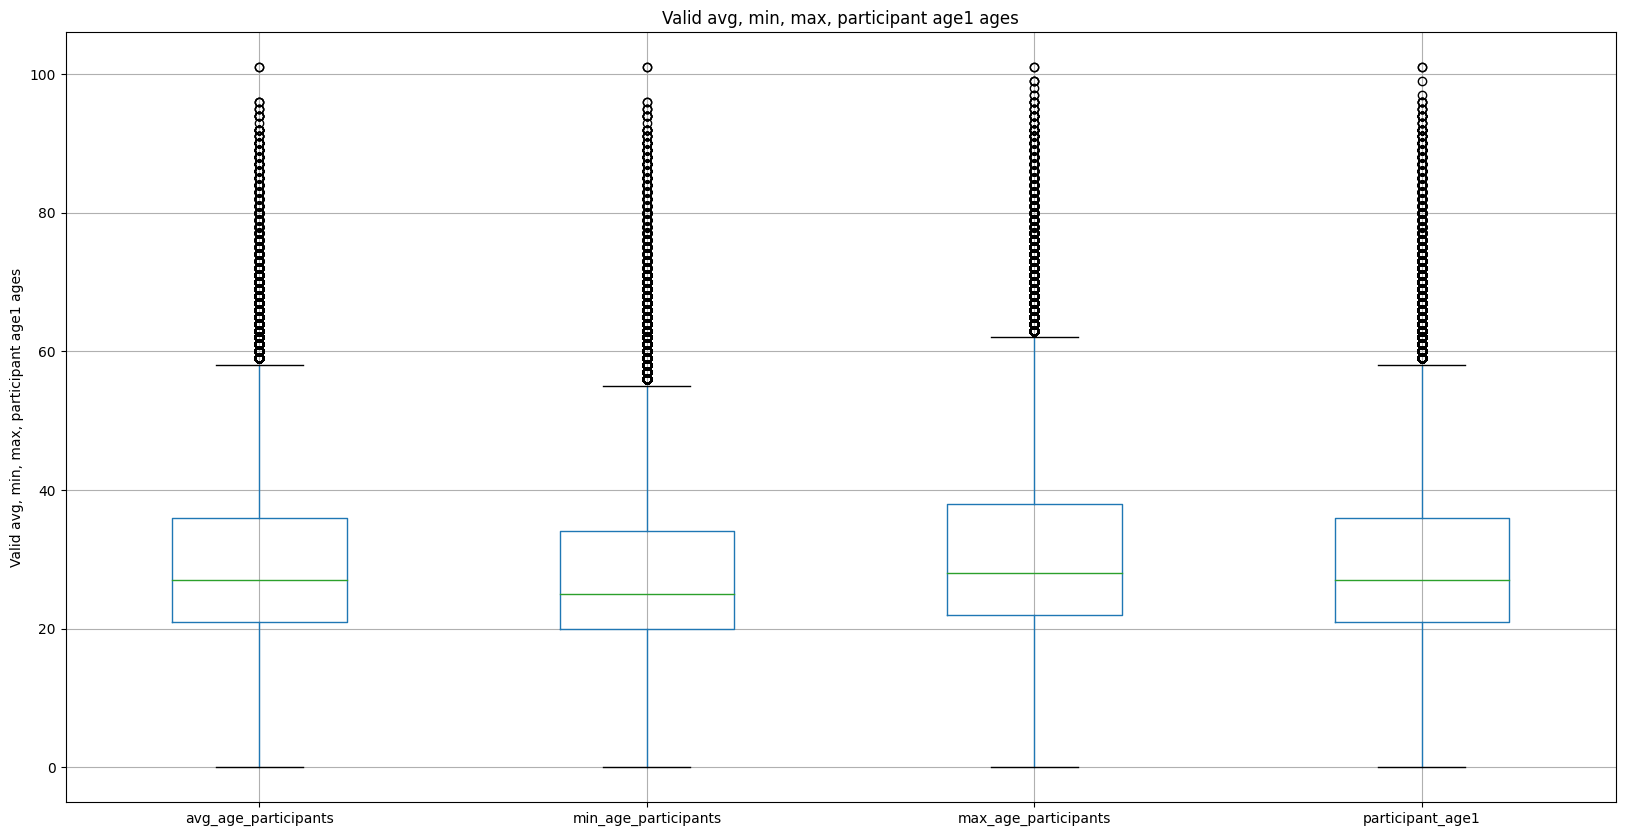

In [625]:
columns = ['avg_age_participants','min_age_participants','max_age_participants', 'participant_age1']
fig, axs = plt.subplots(4, figsize=(10, 12))  # Create 5 subplots

titles = ["Valid avg participant age", "Valid min participant age", "Valid max participant age", "Valid participant age1 age"]
xlabels = ["avg age", "min age", "max age", "participant age1 age"]
ylabels = ["Individuals"] * 4  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=['avg_age_participants', 'min_age_participants', 'max_age_participants', 'participant_age1'], figsize=(20,10))
plt.title("Valid avg, min, max, participant age1 ages")
plt.ylabel("Valid avg, min, max, participant age1 ages")
plt.show()

In [626]:
df[['avg_age_participants', 'participant_age1', 'min_age_participants', 'max_age_participants']].describe()

,avg_age_participants,participant_age1,min_age_participants,max_age_participants
count,136166.0,136166.0,136170.0,136167.0
mean,29.974568,30.260674,28.32538,31.764561
std,12.461766,13.343979,12.498983,13.710215
min,0.0,0.0,0.0,0.0
25%,21.0,21.0,20.0,22.0
50%,27.0,27.0,25.0,28.0
75%,36.0,36.0,34.0,38.0
max,101.0,101.0,101.0,101.0


We notice from eliminated obvious outliers (>120 and <0 years of age) and plotting the results that [avg_age,min_age,max_age]_participants are very similar (same min and max age, similar mean and median), so we decide that we will further explore their correlation. 

We check if when avg_age_participants is 0 or null, we can infer it by calcultating the avg based on min_age_participants and max_age_participants, and we found 0 rows available.
This is a further motivation to delete min and max age participants

In [627]:
df[((df['avg_age_participants'] == 0) | (df['avg_age_participants'].isna())) & (((df['min_age_participants'] > 0) & (df['min_age_participants'].notna())) & ((df['max_age_participants'] > 0) & df['min_age_participants'].notna() ))] [['avg_age_participants', 'min_age_participants', 'max_age_participants']]

,avg_age_participants,min_age_participants,max_age_participants


## Date

Analysis and cleaning of the date attribute

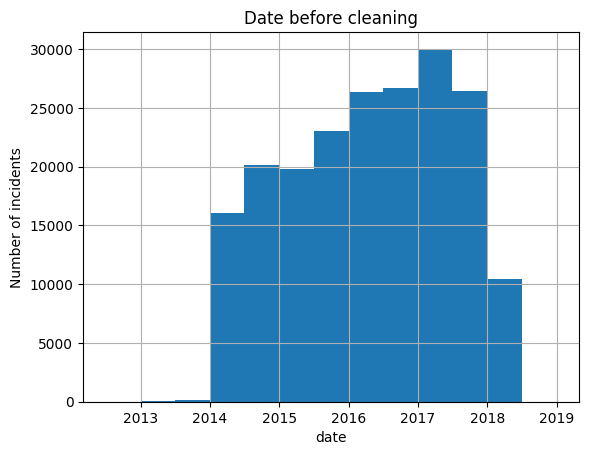

In [628]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date before cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

We considered all dates after 2023-10-01 (the date we received the dataset) to be ouliers, in particular error in the data

As seen in D.U., the year 2013 is under represented with only 242 records, so we decide to drop them. 

For the first delivery we decided to keep all the 2018 records in the dataset, but we will probably analyze them separately after. 

In [629]:
df['date'].dt.year.value_counts().sort_index()

date
2013      242
2014    36248
2015    42804
2016    53051
2017    56365
2018    10415
Name: count, dtype: int64

In [630]:
df_with_2013 = len(df)
df = df[df['date'].dt.year > 2013]
print(df_with_2013 - len(df))

242


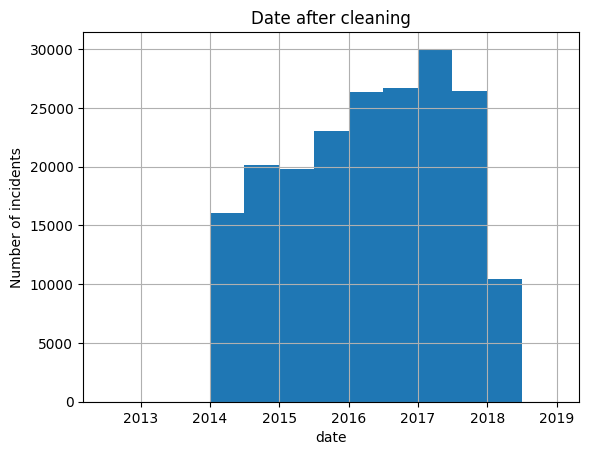

In [631]:
df.hist(column=["date"],   bins=[datetime.datetime(2012,7,1,0,0), datetime.datetime(2013,1,1,0,0), datetime.datetime(2013,7,1,0,0),
                             datetime.datetime(2014,1,1,0,0), datetime.datetime(2014,7,1,0,0), datetime.datetime(2015,1,1,0,0),
                             datetime.datetime(2015,7,1,0,0), datetime.datetime(2016,1,1,0,0), datetime.datetime(2016,7,1,0,0),
                             datetime.datetime(2017,1,1,0,0), datetime.datetime(2017,7,1,0,0), datetime.datetime(2018,1,1,0,0),
                             datetime.datetime(2018,7,1,0,0), datetime.datetime(2019,1,1,0,0)])
plt.title("Date after cleaning")
plt.xlabel("date")
plt.ylabel("Number of incidents")
plt.show()

# Geographical info
('latitude', 'longitude', 'congressional_district', 'state_house_district', 'state_senate_district')

## Latitude and longitude

We consider the triple <date,latitude,longitude> to be a key identifying an incident. We decided to eliminate the records with these 3 values duplicates, because seeing also the notes and the incidents characteristics, the records with the same key represent the same incident  

In [632]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date', 'incident_characteristics1', 'notes']].value_counts()

latitude  longitude  date        incident_characteristics1                          notes                                            
38.5844   -121.4940  2014-03-20  ATF/LE Confiscation/Raid/Arrest                    ATF/LE                                               2
39.1613   -76.6734   2014-08-12  TSA Action                                         Baltimore / Washington International Airport         2
39.7684   -86.1581   2014-02-01  Armed robbery with injury/death and/or evidenc...  Armed robbery.                                       2
29.9872   -95.3477   2015-03-12  Non-Shooting Incident                              George Bush Intercontinental Airport                 2
41.9779   -91.6656   2015-04-01  Non-Shooting Incident                              Incident date unspecified.                           2
                                                                                                                                        ..
33.6356   -84.4333   2014-07-09 

In [633]:
print(f"records before cleaning: {len(df)}")
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(f"records after cleaning: {len(df)}")

records before cleaning: 198883
records after cleaning: 197925


In [634]:
df[df.duplicated(subset=['latitude', 'longitude', 'date'], keep=False)][['latitude', 'longitude', 'date']].value_counts()

Series([], Name: count, dtype: int64)

## Filling of missing values and outliers

We decide to repalce NaN value for latitude and longitude with the mean values for latitude and longitude in the same state and in the same city_or_county.

In [635]:

df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"],group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state",group_keys=False)[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']].isna().any()

latitude     False
longitude    False
dtype: bool

## Congressional District, State House District, State Senate District

By examining the columns ‘congressional_district’, ‘state_house_district’, and ‘state_senate_district’, we observe that the columns ‘state_house_district’ and ‘state_senate_district’ represent further subdivisions of the US territory, which are not pertinent to our analysis. We will utilize the ‘congressional_district’ column to study the territorial divisions.

In [636]:
df.drop(columns=['state_house_district', 'state_senate_district'], inplace=True)

# Participant quantity information 
('n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants')

## N killed, injured, arrested, unharmed

N killed and N injured have no NaN values after the previous steps of cleaning, so we proceed to fix N arrested and N unharmed missing values.

In [637]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 197925 entries, 85424 to 199339
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    197925 non-null  Float64
 1   n_injured   197925 non-null  Float64
 2   n_arrested  173539 non-null  Float64
 3   n_unharmed  173539 non-null  Float64
dtypes: Float64(4)
memory usage: 8.3 MB


We check if each column in n_[killed, injured, arrested, unharmed] does not exceed the n of participants to that incident and the result is that no record exceeds this number.  

In [638]:
columns_to_check = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
for column in columns_to_check:
    df.loc[df[column] > df['n_participants'], column] = np.nan

In [639]:
df[columns_to_check].info()

<class 'pandas.core.frame.DataFrame'>
Index: 197925 entries, 85424 to 199339
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    197925 non-null  Float64
 1   n_injured   197925 non-null  Float64
 2   n_arrested  173539 non-null  Float64
 3   n_unharmed  173539 non-null  Float64
dtypes: Float64(4)
memory usage: 8.3 MB


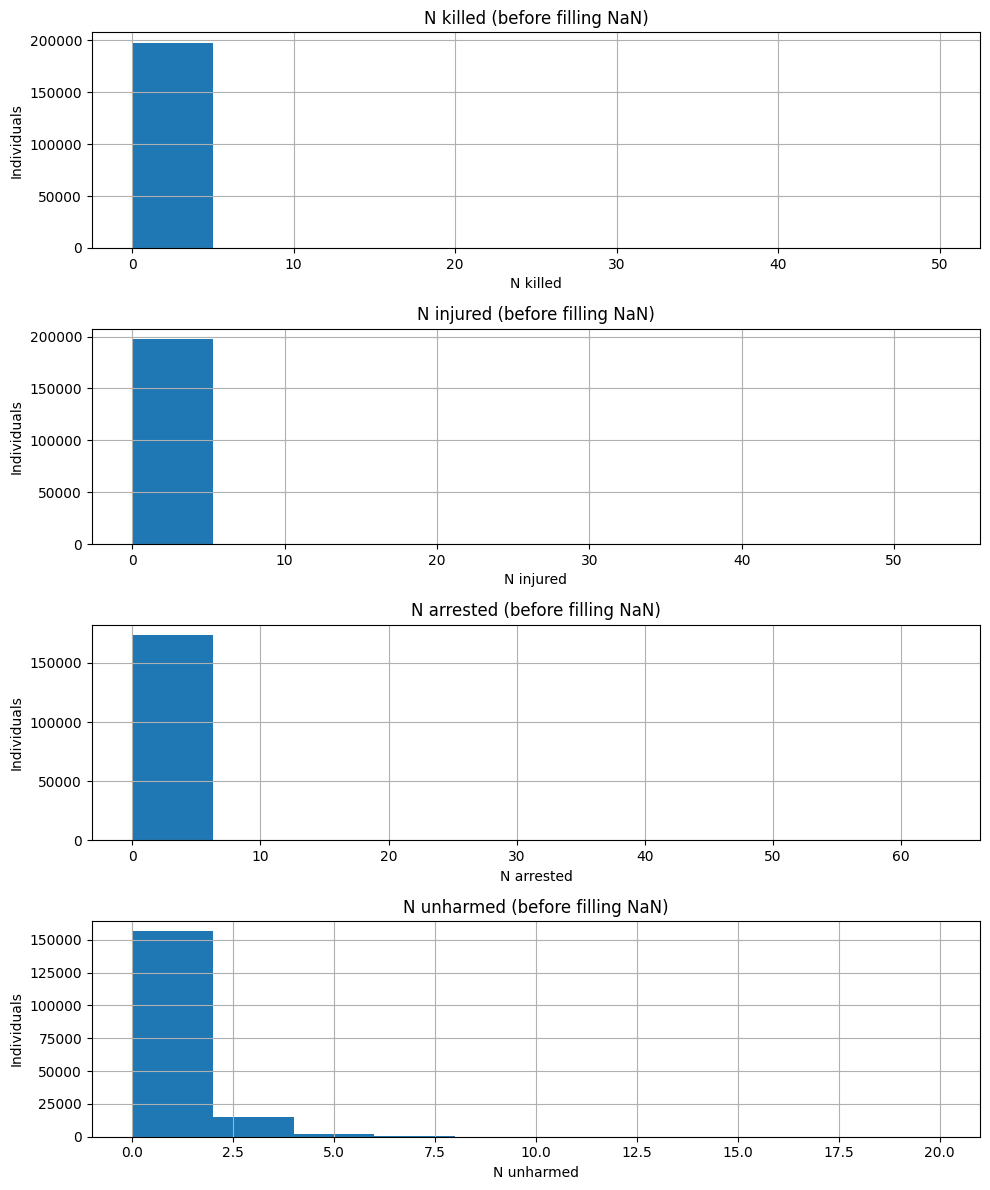

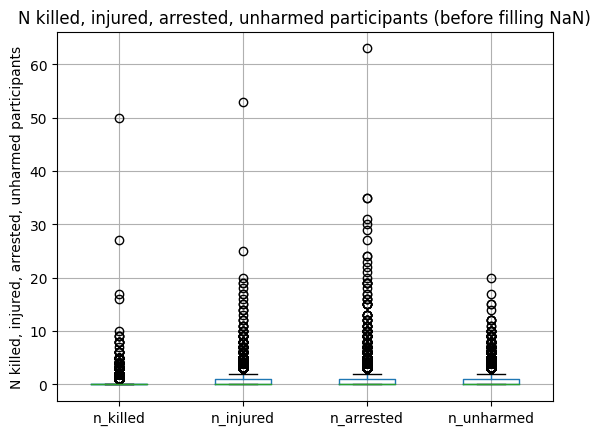

In [640]:
fig, axs = plt.subplots(4, figsize=(10, 12))  # Create 5 subplots

titles = ["N killed (before filling NaN)", "N injured (before filling NaN)", "N arrested (before filling NaN)", "N unharmed (before filling NaN)"]
xlabels = ["N killed", "N injured", "N arrested", "N unharmed"]
ylabels = ["Individuals"] * 4  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns_to_check, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (before filling NaN)")
plt.ylabel("N killed, injured, arrested, unharmed participants")
plt.show()

In [641]:
df[columns_to_check].describe()

,n_killed,n_injured,n_arrested,n_unharmed
count,197925.0,197925.0,173539.0,173539.0
mean,0.263049,0.489832,0.504227,0.44439
std,0.532272,0.727591,0.877225,0.878198
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,1.0,1.0,1.0
max,50.0,53.0,63.0,20.0


We put to 0 arrested and unharmed in all the cases in which there is 0 participants.

In [642]:
df.loc[df["n_participants"] == 0, ['n_arrested', 'n_unharmed']] = 0

Fill the remaining null values with the mean

In [643]:
def fillna_group_arrested_unharmed(group):
    group["n_arrested"] = group["n_arrested"].fillna(np.round(group["n_arrested"].mean(),0))
    group["n_unharmed"] = group["n_unharmed"].fillna(np.round(group["n_unharmed"].mean(),0))
    return group

In [644]:
df = df.groupby("n_participants").apply(fillna_group_arrested_unharmed).reset_index(drop=True)

In [645]:
df[['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   n_killed    197925 non-null  Float64
 1   n_injured   197925 non-null  Float64
 2   n_arrested  197925 non-null  Float64
 3   n_unharmed  197925 non-null  Float64
dtypes: Float64(4)
memory usage: 6.8 MB


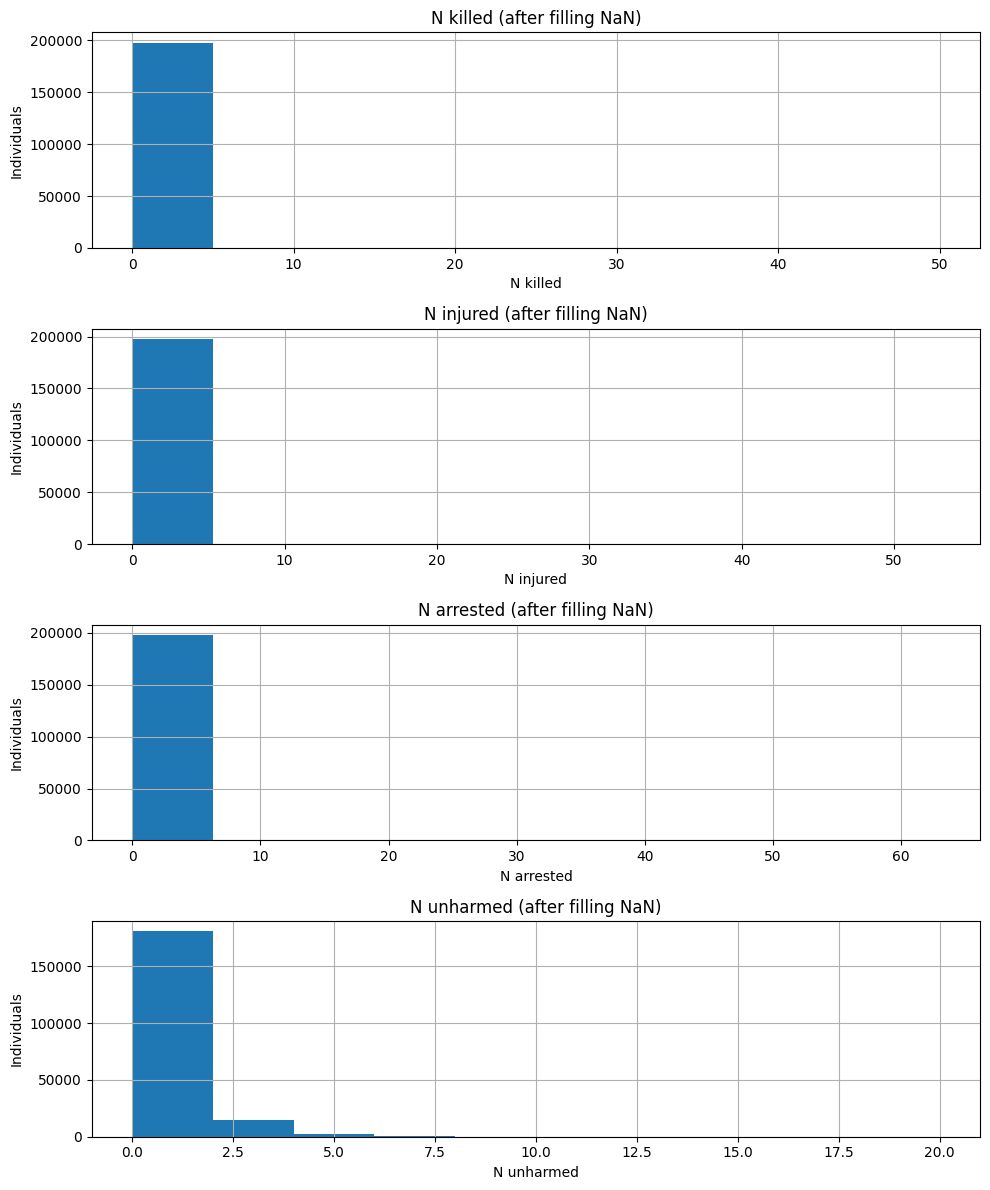

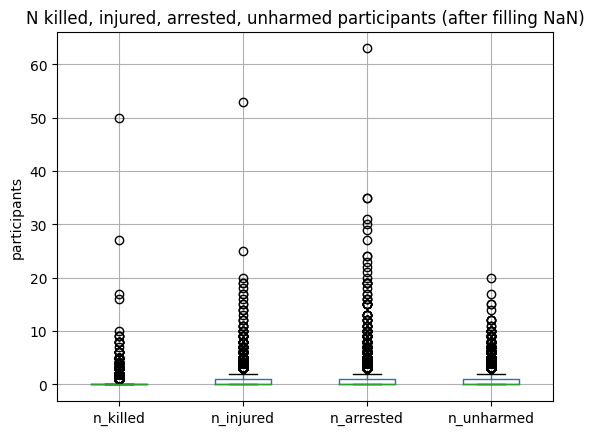

In [646]:
fig, axs = plt.subplots(4, figsize=(10, 12))  

titles = ["N killed (after filling NaN)", "N injured (after filling NaN)", "N arrested (after filling NaN)", "N unharmed (after filling NaN)"]
xlabels = ["N killed", "N injured", "N arrested", "N unharmed"]
ylabels = ["Individuals"] * 4 

for ax, column, title, xlabel, ylabel in zip(axs, columns_to_check, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()

df.boxplot(column=columns_to_check)
plt.title("N killed, injured, arrested, unharmed participants (after filling NaN)")
plt.ylabel("participants")
plt.show()

In [647]:
df[columns_to_check].describe()

,n_killed,n_injured,n_arrested,n_unharmed
count,197925.0,197925.0,197925.0,197925.0
mean,0.263049,0.489832,0.447907,0.395463
std,0.532272,0.727591,0.838685,0.836351
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,0.0,1.0,1.0,1.0
max,50.0,53.0,63.0,20.0


As we can see from the plots before and after filling NaN values, there is no major change in the distributions of these variables 

## N participants [child, teen, adult] and n males and n females

As we observed in D.U., for n_participants[_child,_teen,_adult] there are outliers represented by enormous values. In data preparation, we decided to clean these data putting them to nan, using the max of the n_participants column (which has no significantly big values).

In [648]:
# n_participants has no evident outliers as seen in D.U., we use max participants as threshold value to filter out the outliers
max_participants = df['n_participants'].max()

df.loc[(df["n_participants_child"] > max_participants), "n_participants_child"] = np.nan
df.loc[(df["n_participants_teen"] > max_participants), "n_participants_teen"] = np.nan
df.loc[(df["n_participants_adult"] > max_participants), "n_participants_adult"] = np.nan

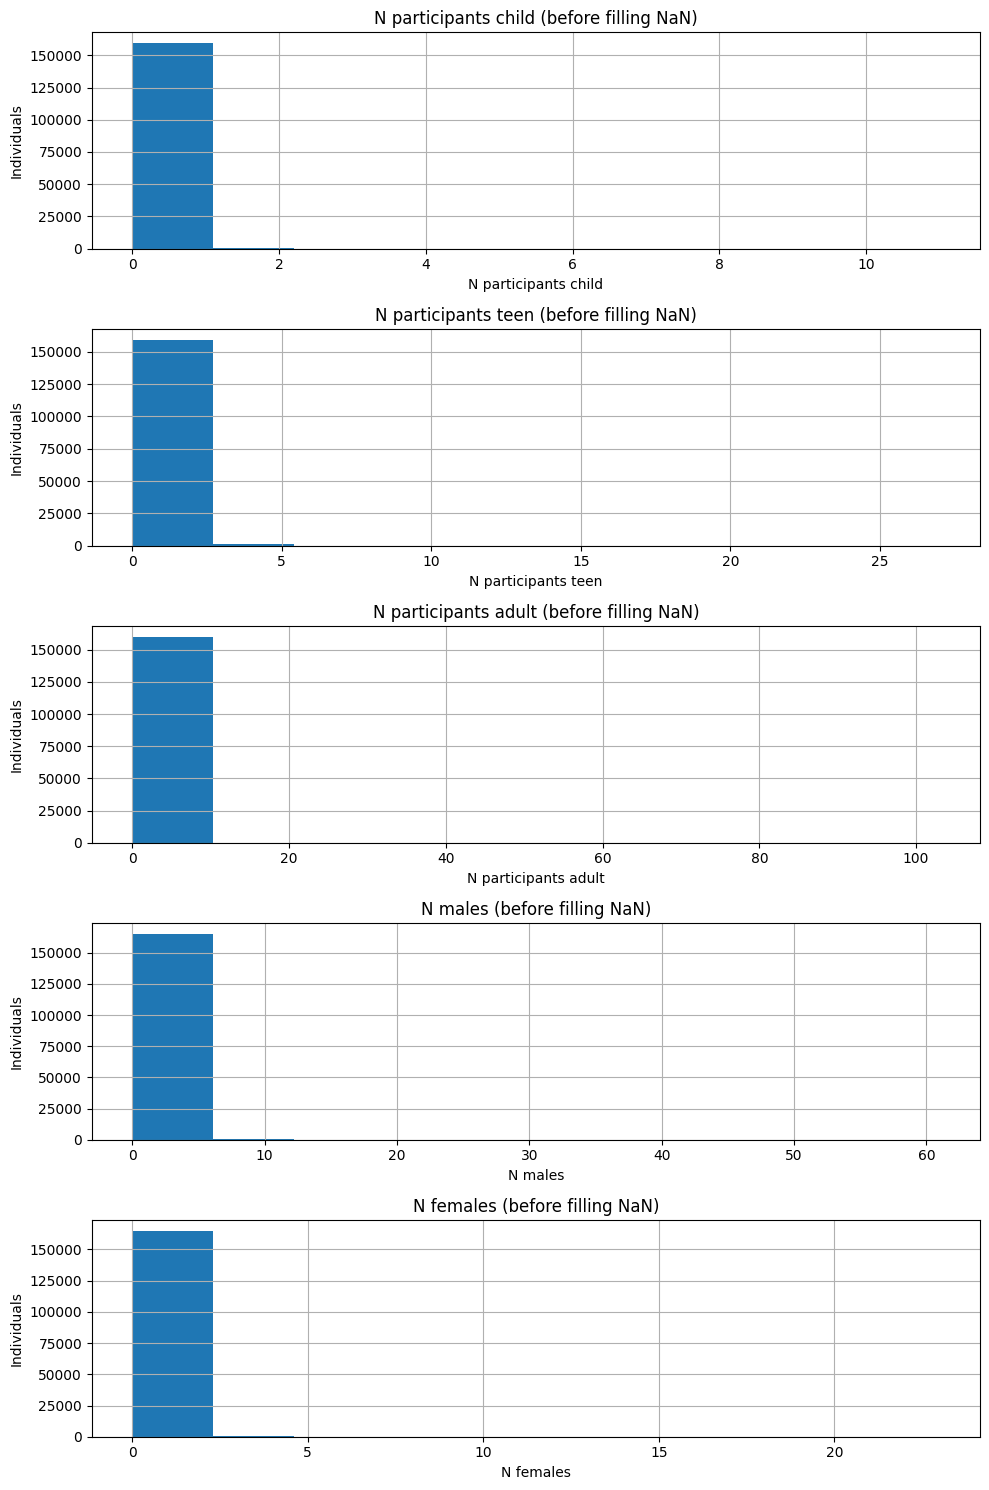

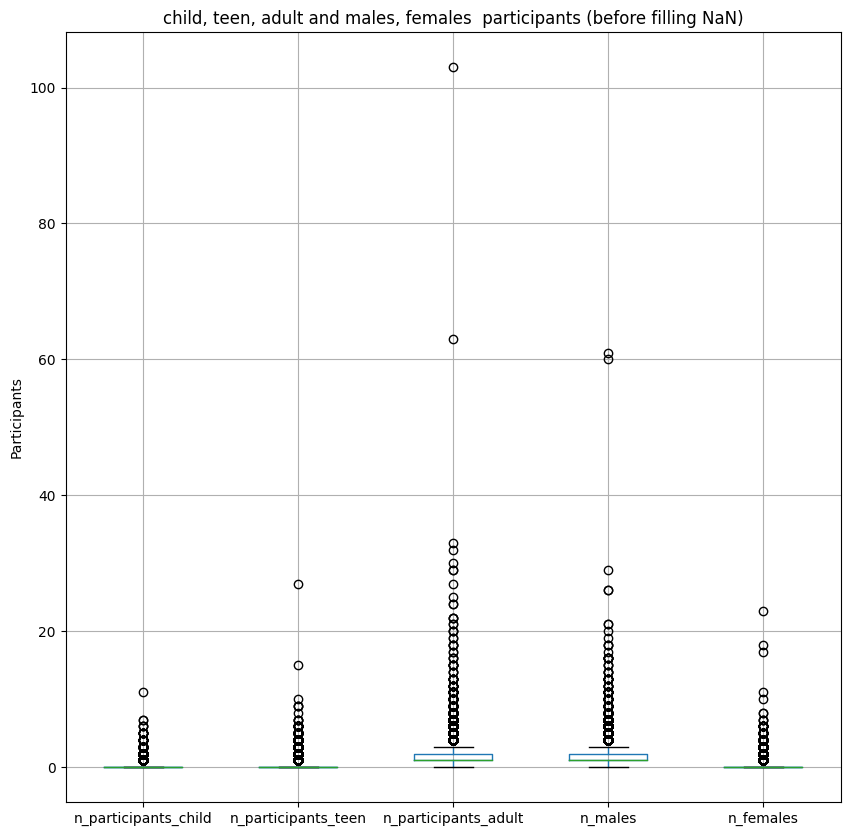

In [649]:
fig, axs = plt.subplots(5, figsize=(10, 15))  # Create 5 subplots

columns = ["n_participants_child", "n_participants_teen", "n_participants_adult", "n_males", "n_females"]
titles = ["N participants child (before filling NaN)", "N participants teen (before filling NaN)", "N participants adult (before filling NaN)", "N males (before filling NaN)", "N females (before filling NaN)"]
xlabels = ["N participants child", "N participants teen", "N participants adult", "N males", "N females"]
ylabels = ["Individuals"] * 5  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()


df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"],  figsize=(10,10))
plt.title("child, teen, adult and males, females  participants (before filling NaN)")
plt.ylabel("Participants")
plt.show()

In [650]:
df[columns].describe()

,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
count,160339.0,160339.0,160339.0,165727.0,165727.0
mean,0.024623,0.140808,1.537567,1.521804,0.215638
std,0.189977,0.470817,1.088892,0.99833,0.495132
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,1.0,1.0,0.0
50%,0.0,0.0,1.0,1.0,0.0
75%,0.0,0.0,2.0,2.0,0.0
max,11.0,27.0,103.0,61.0,23.0


If n participants 0, fill all the other info about the number of people to 0

In [651]:
df.loc[df["n_participants"] == 0, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]] = 0

We try to reconstruct the n_participants attribute values in the different cases:

1- when n participants number was non-coherent with the sum of n_[males,females] and n_participants_[child,teen,adult] (when the sum of the values of these attributes is equal), we substitute it with the sum of n[_males,females] (the same would have been with substituting with n_participants_[child,teen,adult])


In [652]:
df['substitute_values'] = df['n_females'] + df['n_males']

# Define the condition for substitution
condition = (
    ((df['n_females'] + df['n_males']) == (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult'])) &
    (df['n_participants'] != (df['n_females'] + df['n_males'])) 
)

# Update the "n_participants" column with the calculated values where the condition is met
df.loc[condition, 'n_participants'] = df.loc[condition, 'substitute_values']

# Drop the temporary "substitute_values" column if needed
df.drop(columns='substitute_values', inplace=True)

df[condition][["n_participants","n_males","n_females", "n_participants_teen", "n_participants_child", "n_participants_adult"]]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
108152,1.0,1.0,0.0,0,0,1
108157,1.0,1.0,0.0,0,0,1
108186,1.0,1.0,0.0,0,0,1
108189,1.0,0.0,1.0,0,0,1
108224,1.0,1.0,0.0,0,0,1
...,...,...,...,...,...,...
197862,1.0,1.0,0.0,0,0,1
197867,14.0,12.0,2.0,4,0,10
197906,22.0,18.0,4.0,0,0,22
197908,20.0,13.0,7.0,8,0,12


2- If there were inconsistency between n_participants and n_participants_[child,teen,adult] or n_participants_[males,females], we set the correspondent values of these attributes to nan.

In [653]:
df['n_participants_gender'] = df['n_females'] + df['n_males']
df['n_participants_age'] = df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']

# null values can be ambiguous, we ignore them for now
df['n_participants_gender'] = df[df['n_participants_gender'].notna()]['n_participants_gender']
df['n_participants_age'] = df[df['n_participants_age'].notna()]['n_participants_age']


condition = (
    ((df['n_participants_gender']) != (df['n_participants_age']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

condition1 = condition & ((df['n_participants'] == (df['n_participants_gender'])))

print(f"Same condition as before but with n participants == female + male: {len(df[condition1])}")

condition2 = condition & ((df['n_participants'] == (df['n_participants_age'])) )

print(f"Same condition as before but with n participants == child + teen + adult: {len(df[condition2])}")

condition3 = condition & (((df['n_participants'] != df['n_participants_gender']) & (df['n_participants'] != df['n_participants_age'])))
                          
print(f"Same condition as before but with n participants != child + teen + adult and != n_males + n_females: {len(df[condition3])}")


Number of male e female != child + teen + adult:  13363
Same condition as before but with n participants == female + male: 8649
Same condition as before but with n participants == child + teen + adult: 4202
Same condition as before but with n participants != child + teen + adult and != n_males + n_females: 512


In [654]:
df.loc[condition3, ["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females","n_participants_age","n_participants_gender"]] = np.nan
df.loc[condition2, ["n_males","n_females","n_participants_gender"]] = np.nan
df.loc[condition1, ["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_age"] != df["n_participants"],["n_participants_child","n_participants_teen", "n_participants_adult","n_participants_age"]] = np.nan
df.loc[df["n_participants_gender"] != df["n_participants"],["n_males","n_females", "n_participants_gender"]] = np.nan

df.drop(columns=['n_participants_age', 'n_participants_gender'], inplace=True)


In [655]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   n_participants_child  172824 non-null  Int64  
 1   n_participants_teen   172824 non-null  Int64  
 2   n_participants_adult  172824 non-null  Int64  
 3   n_males               181641 non-null  Float64
 4   n_females             181641 non-null  Float64
dtypes: Float64(2), Int64(3)
memory usage: 8.5 MB


In [656]:
#df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]

Then we fill each missing value in each attributes with the mean values grouped by the number of participants such that the sum of n_[males,females] and n_participants_[child,teen,adult] doesn't exceed the number of participants  

In [657]:
#putting in males the first element from males_females
group_by = df.groupby("n_participants",group_keys=False)
for name, group in group_by:
    males_mean = group["n_males"].mean()
    females_mean = group["n_females"].mean()
    participants_child_mean = group["n_participants_child"].mean()
    participants_teen_mean = group["n_participants_teen"].mean()
    participants_adult_mean = group["n_participants_adult"].mean()

    if (pd.notna(males_mean) and pd.notna(females_mean)):
        df.loc[(df["n_males"].isna()) & (df["n_participants"] == name),"n_males"] = np.round(males_mean,0)
        df.loc[(df["n_females"].isna()) & (df["n_participants"] == name),"n_females"] = np.round(females_mean,0)

    if (pd.notna(participants_child_mean) and pd.notna(participants_teen_mean) and pd.notna(participants_adult_mean)):
        df.loc[(df["n_participants_child"].isna()) & (df["n_participants"] == name),"n_participants_child"] = np.round(participants_child_mean,0)
        df.loc[(df["n_participants_teen"].isna()) & (df["n_participants"] == name),"n_participants_teen"] = np.round(participants_teen_mean,0)
        df.loc[(df["n_participants_adult"].isna()) & (df["n_participants"] == name),"n_participants_adult"] = np.round(participants_adult_mean,0)


In [658]:
#df[df["n_participants"] == 17][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]


In [659]:
df[["n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197925 entries, 0 to 197924
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   n_participants_child  197922 non-null  Int64  
 1   n_participants_teen   197922 non-null  Int64  
 2   n_participants_adult  197922 non-null  Int64  
 3   n_males               197917 non-null  Float64
 4   n_females             197917 non-null  Float64
dtypes: Float64(2), Int64(3)
memory usage: 8.5 MB


All the data in which we can't reconstruct the mean were few (only 8) and for this reason were dropped

In [660]:
df[(df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna())][["n_participants","n_males","n_females",'n_participants_teen','n_participants_child','n_participants_adult']]

,n_participants,n_males,n_females,n_participants_teen,n_participants_child,n_participants_adult
197907,24.0,<NA>,<NA>,0,0,24
197909,24.0,<NA>,<NA>,0,0,24
197910,24.0,<NA>,<NA>,0,0,24
197916,30.0,<NA>,<NA>,0,0,30
197920,37.0,<NA>,<NA>,<NA>,<NA>,<NA>
197921,47.0,<NA>,<NA>,<NA>,<NA>,<NA>
197922,52.0,<NA>,<NA>,<NA>,<NA>,<NA>
197924,103.0,<NA>,<NA>,0,0,103


In [661]:
df = df[~((df["n_males"].isna() & df["n_females"].isna()) | (df['n_participants_teen'].isna() & df['n_participants_child'].isna() & df['n_participants_adult'].isna()))]

Morevover, the mean missed only for few other records (3) that for now we decided to drop them. 

In [662]:
condition = (
    ((df['n_females'] + df['n_males']) != (df['n_participants_teen'] + df['n_participants_child'] + df['n_participants_adult']))   
)

print(f"Number of male e female != child + teen + adult:  {len(df[condition])}")

Number of male e female != child + teen + adult:  3


In [663]:
df.loc[condition, ["n_participants","n_participants_child","n_participants_teen", "n_participants_adult", "n_males", "n_females"]]

,n_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
197881,17.0,0,0,17,12.0,4.0
197884,17.0,0,0,17,12.0,4.0
197886,17.0,0,0,17,12.0,4.0


In [664]:
df = df[~condition]

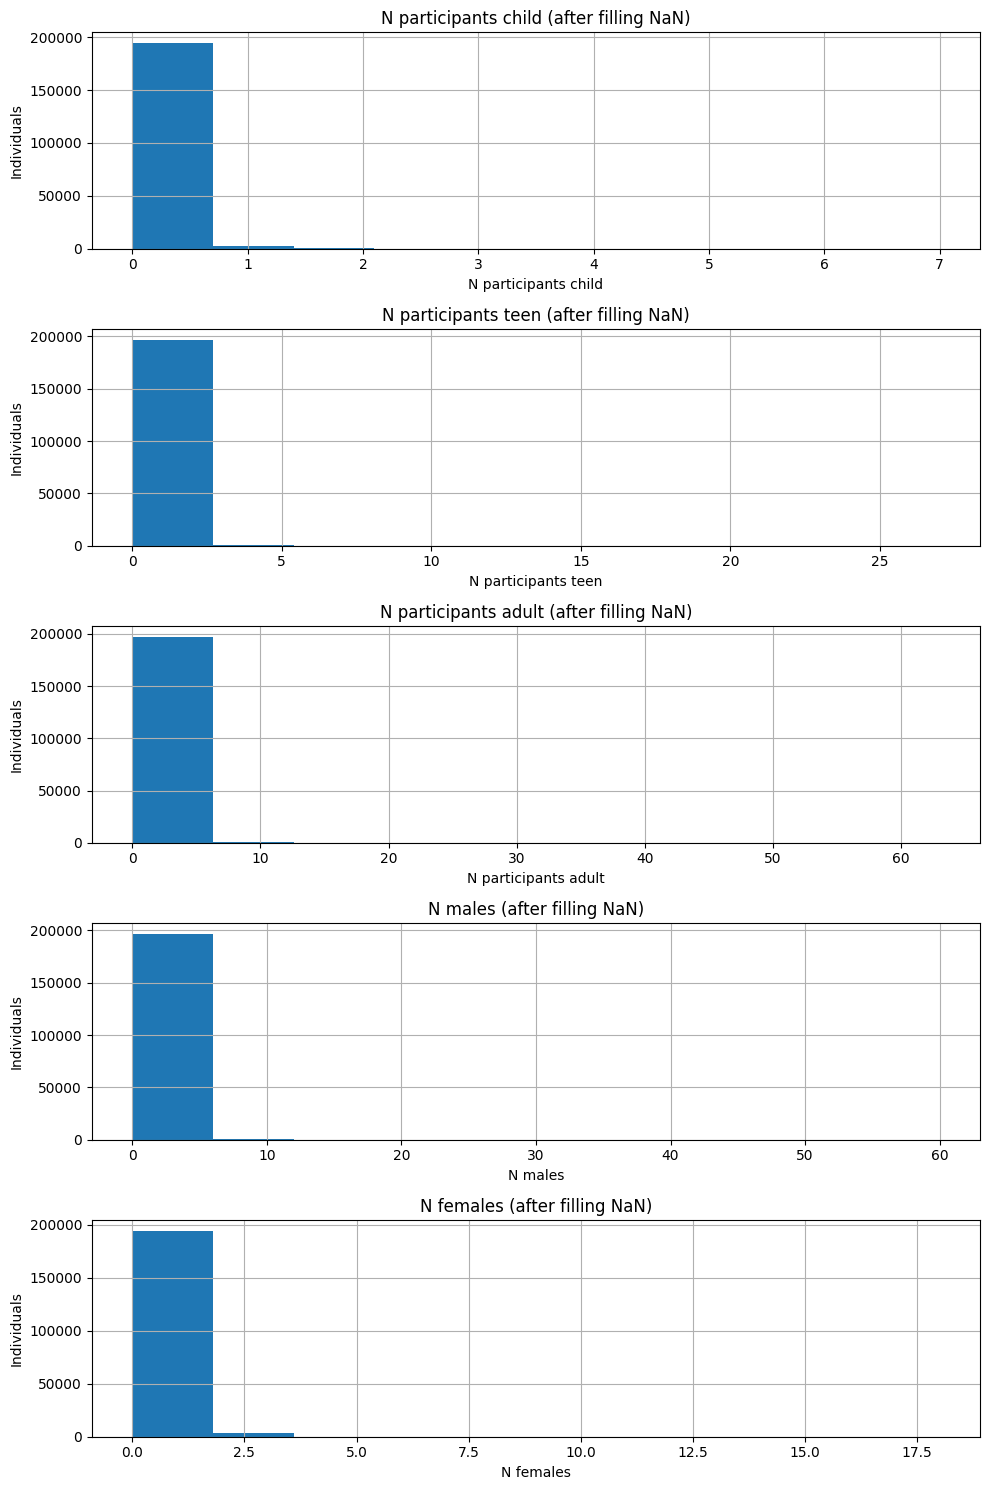

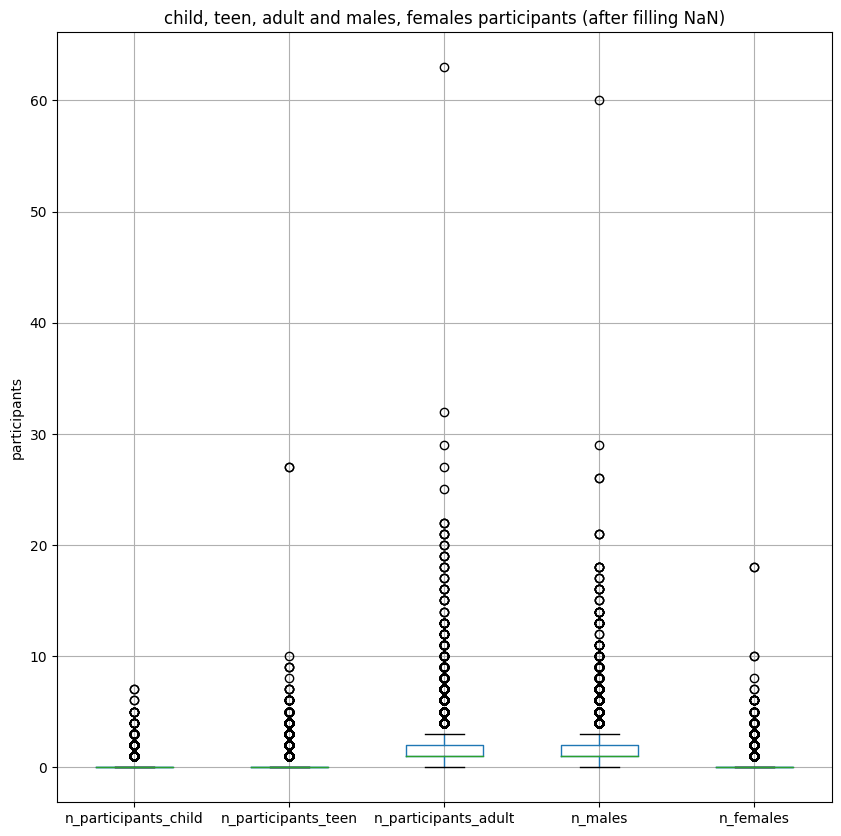

In [665]:
fig, axs = plt.subplots(5, figsize=(10, 15))  # Create 5 subplots

columns = ["n_participants_child", "n_participants_teen", "n_participants_adult", "n_males", "n_females"]
titles = ["N participants child (after filling NaN)", "N participants teen (after filling NaN)", "N participants adult (after filling NaN)", "N males (after filling NaN)", "N females (after filling NaN)"]
xlabels = ["N participants child", "N participants teen", "N participants adult", "N males", "N females"]
ylabels = ["Individuals"] * 5  # Same ylabel for all

for ax, column, title, xlabel, ylabel in zip(axs, columns, titles, xlabels, ylabels):
    df.hist(column=column, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

plt.tight_layout()
plt.show()


df.boxplot(column=["n_participants_child","n_participants_teen", "n_participants_adult",  "n_males", "n_females"], figsize=(10,10))
plt.title("child, teen, adult and males, females participants (after filling NaN)")
plt.ylabel("participants")
plt.show()

In [666]:
df[columns].describe()

,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females
count,197914.0,197914.0,197914.0,197914.0,197914.0
mean,0.019039,0.112594,1.448089,1.394222,0.1855
std,0.165582,0.424661,1.142854,1.076181,0.458913
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,1.0,1.0,0.0
50%,0.0,0.0,1.0,1.0,0.0
75%,0.0,0.0,2.0,2.0,0.0
max,7.0,27.0,63.0,60.0,18.0


As we can see from the plots before and after filling NaN values, there is no relevant change in the distributions of these variables 

# Incident characteristics 1

In [667]:
df['incident_characteristics1'].info()

<class 'pandas.core.series.Series'>
Index: 197914 entries, 0 to 197923
Series name: incident_characteristics1
Non-Null Count   Dtype 
--------------   ----- 
197641 non-null  string
dtypes: string(1)
memory usage: 3.0 MB


We decided to fill the missing values for this attribute with its mode (they are few, so we didn't plot the distribution)

In [668]:
df['incident_characteristics1'] = df['incident_characteristics1'].fillna(df['incident_characteristics1'].mode()[0])

# Incident characteristics 2

In [669]:
df['incident_characteristics2'].info()

<class 'pandas.core.series.Series'>
Index: 197914 entries, 0 to 197923
Series name: incident_characteristics2
Non-Null Count   Dtype 
--------------   ----- 
118425 non-null  string
dtypes: string(1)
memory usage: 3.0 MB


In [670]:
print(f" percentage of null values: {df['incident_characteristics2'].isna().sum() / len(df['incident_characteristics2'])}")

 percentage of null values: 0.40163404306921185


For now, since incident_characteristics2 has 40% of missing values and add only further details that we consider useless for our analysis, we decided to drop it. 

In [671]:
df[df['incident_characteristics1'] == "Shot - Wounded/Injured" ][['incident_characteristics1','incident_characteristics2']].value_counts(dropna=False).head()

incident_characteristics1  incident_characteristics2                        
Shot - Wounded/Injured     <NA>                                                 38565
                           Shot - Dead (murder, accidental, suicide)             7108
                           Drive-by (car to street, car to car)                  5866
                           Accidental Shooting                                   3209
                           Armed robbery with injury/death and/or evidenc...     3011
Name: count, dtype: int64

In [672]:
df.drop(columns=['incident_characteristics2'], inplace=True)

# Correlation Matrix Analysis

In [673]:
corr_matrix = df[['participant_age1', 'participant_age_group1',
       'participant_gender1', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'povertyPercentage']].corr(numeric_only=True, method='pearson')
corr_matrix

,participant_age1,min_age_participants,avg_age_participants,max_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,povertyPercentage
participant_age1,1.000000,0.878260,0.945387,0.926643,-0.177334,-0.256170,0.109591,-0.065534,0.067696,0.146681,-0.122233,-0.025916,-0.008665,-0.029498,0.033266
min_age_participants,0.878260,1.000000,0.951506,0.812162,-0.226368,-0.302624,-0.019999,-0.193070,-0.018982,0.061702,-0.152522,-0.108885,-0.045980,-0.183312,0.013536
avg_age_participants,0.945387,0.951506,1.000000,0.948623,-0.175819,-0.286476,0.087156,-0.100377,0.061805,0.136316,-0.121642,-0.053004,-0.020807,-0.063669,0.030005
max_age_participants,0.926643,0.812162,0.948623,1.000000,-0.110643,-0.232381,0.196619,0.015735,0.140880,0.196964,-0.076305,0.021600,0.009898,0.076438,0.043061
n_participants_child,-0.177334,-0.226368,-0.175819,-0.110643,1.000000,0.011838,-0.015817,0.081763,0.140637,0.062697,0.052604,-0.012359,0.107527,0.127849,0.031875
n_participants_teen,-0.256170,-0.302624,-0.286476,-0.232381,0.011838,1.000000,-0.088756,0.252610,0.116213,0.024424,0.113431,0.201504,0.077144,0.272564,0.013818
n_participants_adult,0.109591,-0.019999,0.087156,0.196619,-0.015817,-0.088756,1.000000,0.858159,0.390072,0.216086,0.331097,0.409661,0.478263,0.924130,0.067971
n_males,-0.065534,-0.193070,-0.100377,0.015735,0.081763,0.252610,0.858159,1.000000,0.055307,0.169472,0.333234,0.437150,0.478381,0.923307,0.060328
n_females,0.067696,-0.018982,0.061805,0.140880,0.140637,0.116213,0.390072,0.055307,1.000000,0.185931,0.167039,0.177057,0.179389,0.434541,0.052085
n_killed,0.146681,0.061702,0.136316,0.196964,0.062697,0.024424,0.216086,0.169472,0.185931,1.000000,-0.175072,-0.035045,-0.103986,0.224388,0.067164


<Axes: >

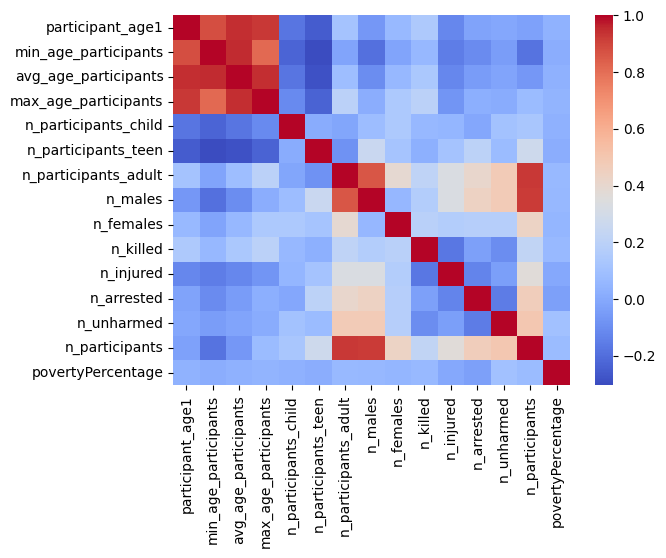

In [674]:
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

As resulted from the plotting of correlation matrix, we can see that attributes related to the age i.e. participant_age1, min_age_participants, 	avg_age_participants, max_age_participants are all high correlated.
We decided to drop everything except avg_age_participants which has the most high correlation w.r.t. other attributes (>0.90) and gives us more general information about all the participants (w.r.t. e.g. participant_age1, which takes the age of one random person involved in the incident.)

Deleting participant_age1, also participant_age_group1 and participant_gender1 becomes useless (also because these information can be inferred respectively from n_participant_[child,teen,adult] and n_[males,females]), so we delete also these attributes. 

In [675]:
df.drop(columns=['participant_age1', 'min_age_participants', 'max_age_participants', 'participant_age_group1', 'participant_gender1'], inplace=True)

## Filling missing values for avg_participants

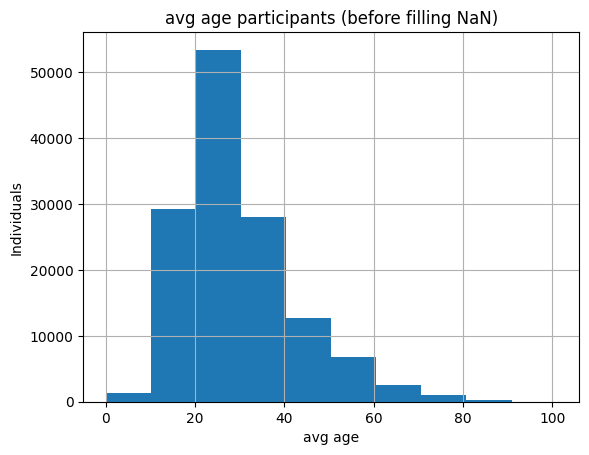

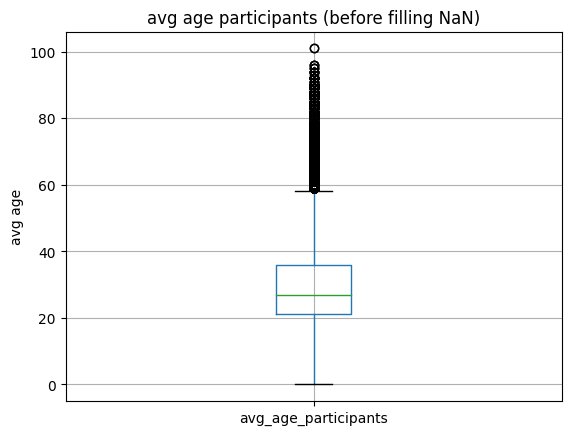

In [676]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (before filling NaN)")
plt.ylabel("avg age")
plt.show()

In [677]:
df["avg_age_participants"].describe()

count     135320.0
mean     29.980934
std      12.465062
min            0.0
25%           21.0
50%           27.0
75%           36.0
max          101.0
Name: avg_age_participants, dtype: Float64

We decide to fill the missing values of avg_age_participants with the mean.

In [678]:
df['avg_age_participants'] = df['avg_age_participants'].fillna(np.round(df['avg_age_participants'].mean(),0))

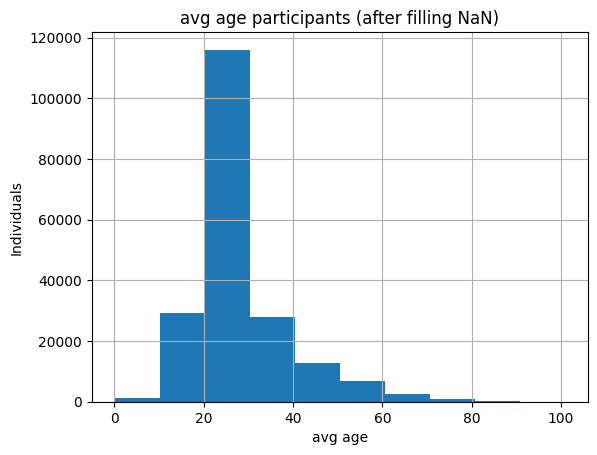

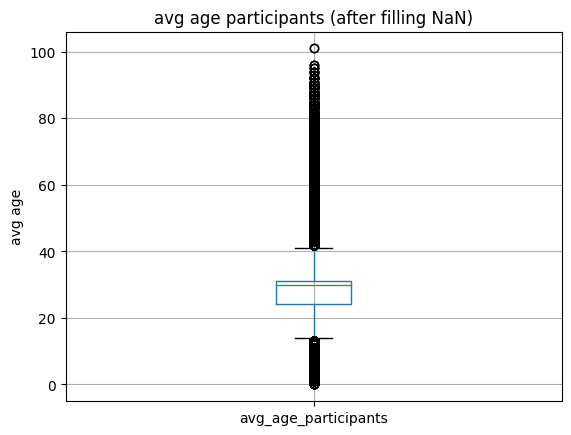

In [679]:
df.hist(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.xlabel("avg age")
plt.ylabel("Individuals")
plt.show()

df.boxplot(column=["avg_age_participants"])
plt.title("avg age participants (after filling NaN)")
plt.ylabel("avg age")
plt.show()

In [680]:
df["avg_age_participants"].describe()

count     197914.0
mean     29.986964
std      10.307108
min            0.0
25%           24.0
50%           30.0
75%           31.0
max          101.0
Name: avg_age_participants, dtype: Float64

# Definition of Indicators (provvisorio)

In [681]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197914 entries, 0 to 197923
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       197914 non-null  datetime64[ns]
 1   state                      197914 non-null  string        
 2   city_or_county             197914 non-null  string        
 3   address                    184525 non-null  string        
 4   latitude                   197914 non-null  float64       
 5   longitude                  197914 non-null  float64       
 6   congressional_district     197914 non-null  Int64         
 7   avg_age_participants       197914 non-null  Float64       
 8   n_participants_child       197914 non-null  Int64         
 9   n_participants_teen        197914 non-null  Int64         
 10  n_participants_adult       197914 non-null  Int64         
 11  n_males                    197914 non-null  Float64      

In [682]:
#How many males are involved in the incident w.r.t. the total number of males involved in incidents for the same congressional district and in the same date
df["males_percentage_per_district"] = df["n_males"] /  df.groupby(["date","state", "congressional_district"])["n_males"].transform("sum")
#handling null value
df.loc[np.isnan(df["males_percentage_per_district"]),"males_percentage_per_district"] = 0

#How many child and teen are involved in the incident w.r.t. the total number of males involved in incidents for the same congressional district and in the same date
df["child_teen_percentage_per_district"] = (df["n_participants_teen"] + df['n_participants_child']) /  (df.groupby(["date","state", "congressional_district"])["n_participants_teen"].transform("sum") + df.groupby(["date","state", "congressional_district"])["n_participants_child"].transform("sum")) 
#handling null value
df.loc[np.isnan(df["child_teen_percentage_per_district"]),"child_teen_percentage_per_district"] = 0 



In [683]:
#How many killed people have been involved w.r.t the total killed people in the same congressional district in a given date
df["killed_percentage_per_district"] = df["n_killed"] /  df.groupby(["date","state", "congressional_district"])["n_killed"].transform("sum")
df.loc[np.isnan(df["killed_percentage_per_district"]),"killed_percentage_per_district"] = 0

#How many injured people have been involved w.r.t the total injured people in the same congressional district in a given date
df["injured_percentage_per_district"] = df["n_injured"] /  df.groupby(["date","state", "congressional_district" ])["n_injured"].transform("sum")
df.loc[np.isnan(df["injured_percentage_per_district"]),"injured_percentage_per_district"] = 0

#How many arrested people have been involved w.r.t the total killed people in the same congressional district in a given date
df["arrested_percentage_per_district"] = df["n_arrested"] /  df.groupby(["date","state",  "congressional_district"])["n_arrested"].transform("sum")
df.loc[np.isnan(df["arrested_percentage_per_district"]),"arrested_percentage_per_district"] = 0

#How many arrested people have been involved w.r.t the total killed people in the same congressional district in a given date
df["unharmed_percentage_per_district"] = df["n_unharmed"] /  df.groupby(["date","state",  "congressional_district"])["n_unharmed"].transform("sum")
df.loc[np.isnan(df["unharmed_percentage_per_district"]),"unharmed_percentage_per_district"] = 0


In [684]:
#Ratio of killed people in the incidents w.r.t. the the average of killed  people in the same date
df["killed_rate"] = df["n_killed"] / df.groupby(['date'])['n_killed'].transform('mean')
df.loc[np.isnan(df["killed_rate"]),"killed_rate"] = 0

#Ratio of injured people in the incidents w.r.t. the the average of injured people in the same date
df["injured_rate"] = df["n_injured"] / df.groupby(['date'])['n_injured'].transform('mean')
df.loc[np.isnan(df["injured_rate"]),"injured_rate"] = 0

#Ratio of arrested people in the incidents w.r.t. the the average of arrested people in the same date
df["arrested_rate"] = df["n_arrested"] / df.groupby(['date'])['n_arrested'].transform('mean')
df.loc[np.isnan(df["arrested_rate"]),"arrested_rate"] = 0

#Ratio of unharmed people in the incidents w.r.t. the the average of unharmed people in the same date
df["survival_rate"] = df["n_unharmed"] / df.groupby(['date'])['n_unharmed'].transform('mean')
df.loc[np.isnan(df["survival_rate"]),"survival_rate"] = 0


In [685]:
# Percentage of votes of the winning party
df['winning_party_percentage'] = df['candidatevotes'] / df['totalvotes']
df.loc[np.isnan(df["winning_party_percentage"]),"winning_party_percentage"] = 0

In [686]:
col_to_plot = [
 'males_percentage_per_district',
 'killed_percentage_per_district',
 'injured_percentage_per_district',
 'arrested_percentage_per_district',
 'unharmed_percentage_per_district',
 'killed_rate',
 'injured_rate',
 'arrested_rate',
 'survival_rate',
 'child_teen_percentage_per_district',
 'winning_party_percentage']

corr_matrix_ind = df[col_to_plot].corr(numeric_only=True, method='pearson')
corr_matrix_ind

,males_percentage_per_district,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_rate,injured_rate,arrested_rate,survival_rate,child_teen_percentage_per_district,winning_party_percentage
males_percentage_per_district,1.000000,0.202139,0.247704,0.316138,0.247341,0.152403,0.108809,0.168590,0.148924,0.095749,-0.090085
killed_percentage_per_district,0.202139,1.000000,-0.231298,-0.027126,-0.084537,0.889267,-0.203596,-0.000080,-0.099022,0.022487,0.031523
injured_percentage_per_district,0.247704,-0.231298,1.000000,-0.157990,0.019278,-0.214868,0.785042,-0.112298,0.003724,0.082065,0.022084
arrested_percentage_per_district,0.316138,-0.027126,-0.157990,1.000000,-0.197164,-0.038418,-0.174823,0.608679,-0.160331,0.072491,-0.095879
unharmed_percentage_per_district,0.247341,-0.084537,0.019278,-0.197164,1.000000,-0.097472,-0.008211,-0.109254,0.757255,0.037244,-0.000652
killed_rate,0.152403,0.889267,-0.214868,-0.038418,-0.097472,1.000000,-0.178671,-0.010491,-0.099561,0.032032,0.032711
injured_rate,0.108809,-0.203596,0.785042,-0.174823,-0.008211,-0.178671,1.000000,-0.110520,-0.004587,0.112977,0.076693
arrested_rate,0.168590,-0.000080,-0.112298,0.608679,-0.109254,-0.010491,-0.110520,1.000000,-0.103011,0.103848,-0.045398
survival_rate,0.148924,-0.099022,0.003724,-0.160331,0.757255,-0.099561,-0.004587,-0.103011,1.000000,0.054255,0.014880
child_teen_percentage_per_district,0.095749,0.022487,0.082065,0.072491,0.037244,0.032032,0.112977,0.103848,0.054255,1.000000,0.006065


<Axes: >

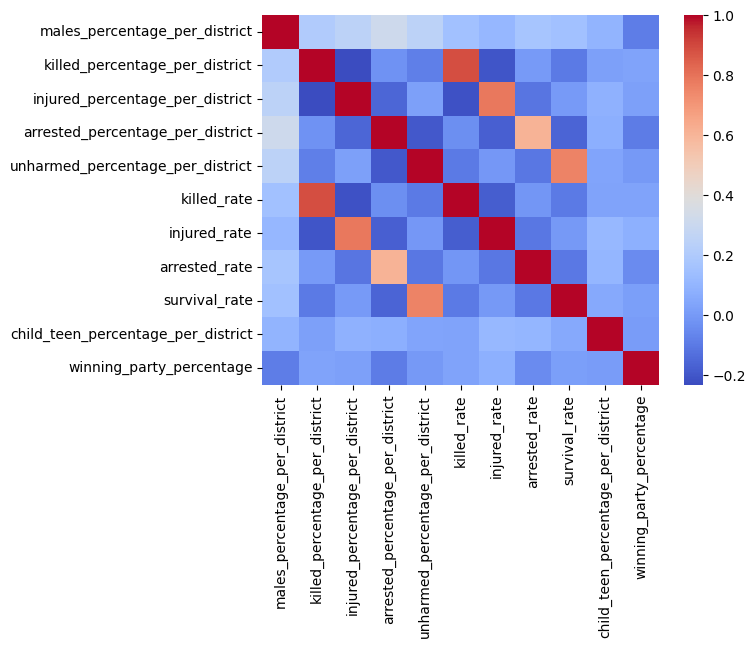

In [687]:
sns.heatmap(corr_matrix_ind, annot=False, cmap='coolwarm')

<Axes: >

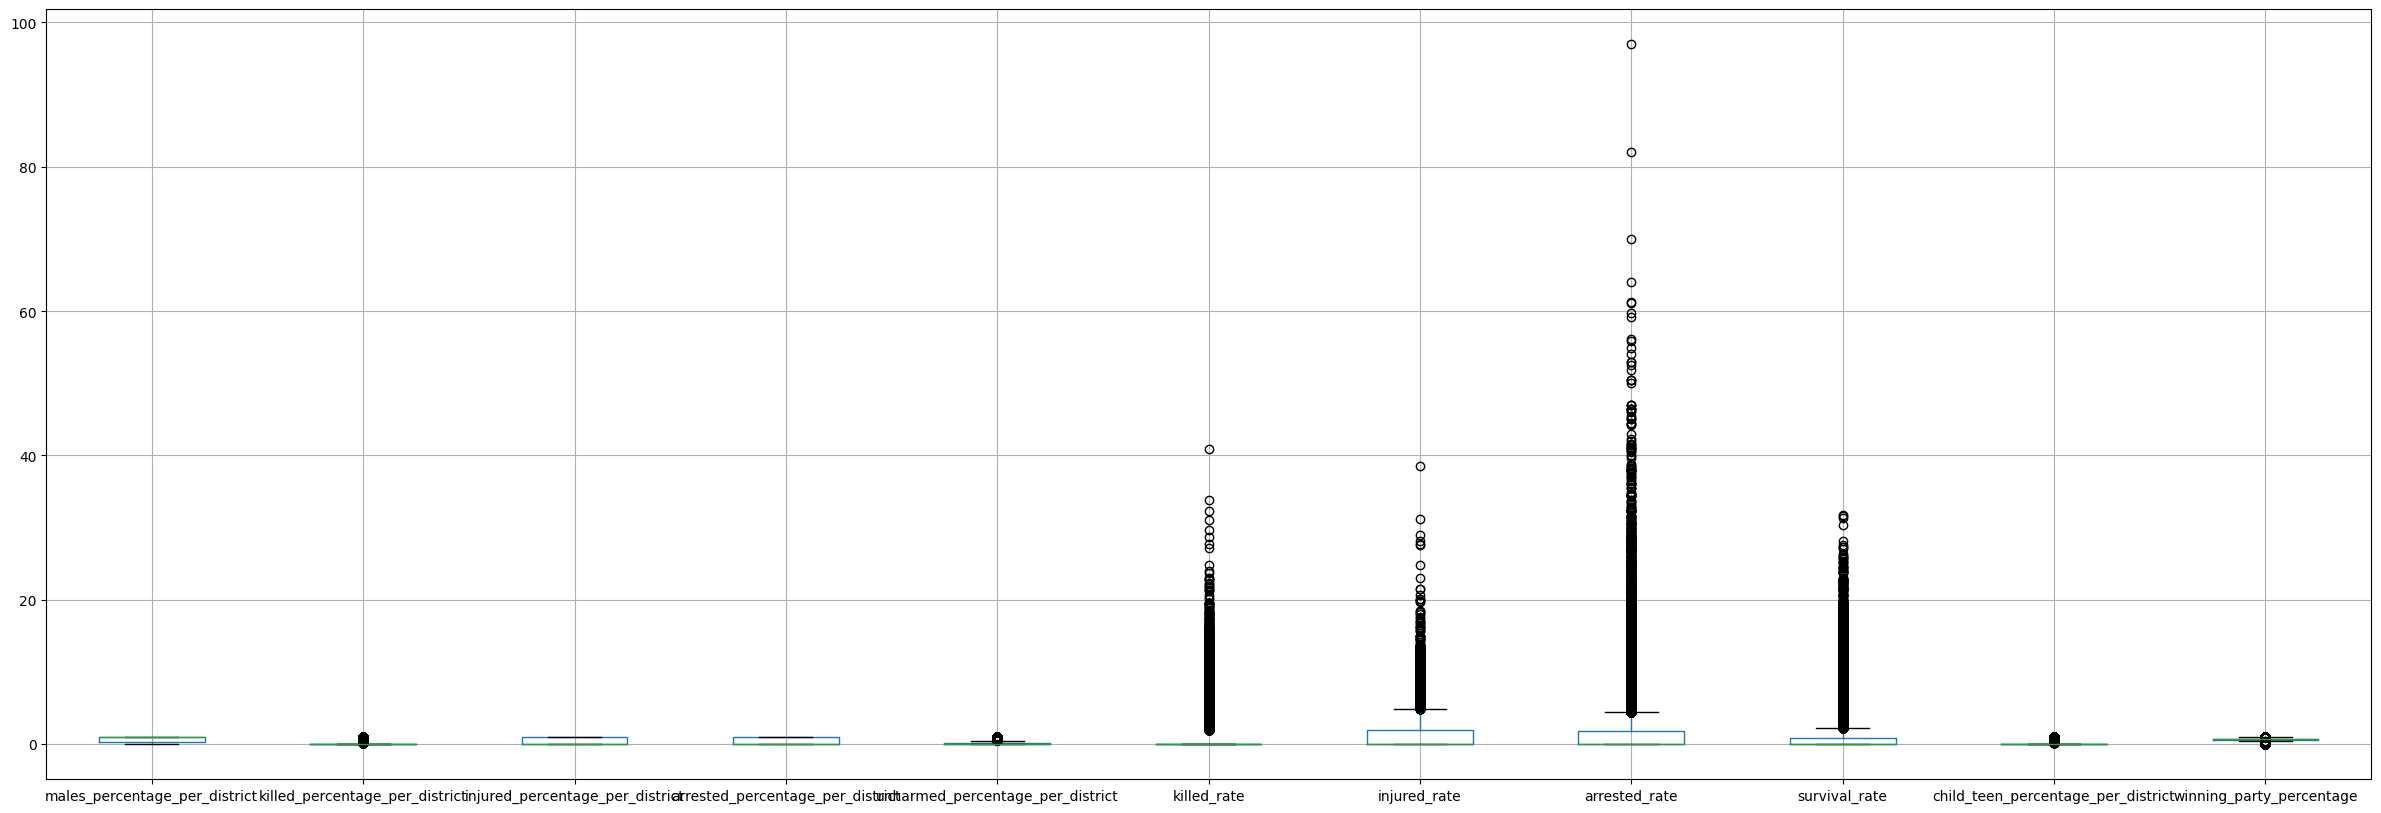

In [688]:
df[col_to_plot].boxplot(figsize=(30,10))

In [689]:
df[col_to_plot].describe()

,males_percentage_per_district,killed_percentage_per_district,injured_percentage_per_district,arrested_percentage_per_district,unharmed_percentage_per_district,killed_rate,injured_rate,arrested_rate,survival_rate,child_teen_percentage_per_district,winning_party_percentage
count,197914.0,197914.0,197914.0,197914.0,197914.0,197914.0,197914.0,197914.0,197914.0,197914.0,197914.0
mean,0.659024,0.214553,0.326844,0.297665,0.226558,1.0,1.0,1.0,1.0,0.095673,0.681462
std,0.392492,0.399548,0.437864,0.441046,0.404737,1.993563,1.455455,2.269076,2.219499,0.290565,0.130646
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.596987
50%,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.66702
75%,1.0,0.0,1.0,1.0,0.2,0.0,1.974026,1.776119,0.917127,0.0,0.749687
max,1.0,1.0,1.0,1.0,1.0,40.880952,38.588235,97.0,31.75,1.0,1.0


For now we keep all the indicators because we think they describe better the incidents, but later we probably drop the most correlated ones

# Further Attributes dropped

As observed in the DU address will be dropped, moreover we will drop also year and notes because the former is a result of the data integration, useless because is redundant as we have the attribute date, the latter is useless because is only a string of text, used only in the data understanding

In [690]:
df.drop(columns=['notes', 'year', 'address'], inplace=True)

In [691]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197914 entries, 0 to 197923
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   date                                197914 non-null  datetime64[ns]
 1   state                               197914 non-null  string        
 2   city_or_county                      197914 non-null  string        
 3   latitude                            197914 non-null  float64       
 4   longitude                           197914 non-null  float64       
 5   congressional_district              197914 non-null  Int64         
 6   avg_age_participants                197914 non-null  Float64       
 7   n_participants_child                197914 non-null  Int64         
 8   n_participants_teen                 197914 non-null  Int64         
 9   n_participants_adult                197914 non-null  Int64         
 10  n_males      

# Export the dataframe after the data preparation

In [692]:
df.to_csv('df_after_dp.csv', index=False)